In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sem-long-project/sem Long project/noisy_file.wav
/kaggle/input/sem-long-project/sem Long project/testingOnOurOwnData.ipynb
/kaggle/input/sem-long-project/sem Long project/audioDenoising.ipynb
/kaggle/input/sem-long-project/sem Long project/our data in wav format/puru_1.wav
/kaggle/input/sem-long-project/sem Long project/our data in wav format/puru_5.wav
/kaggle/input/sem-long-project/sem Long project/our data in wav format/puru_4.wav
/kaggle/input/sem-long-project/sem Long project/our data in wav format/puru_2.wav
/kaggle/input/sem-long-project/sem Long project/our data in wav format/puru_3.wav
/kaggle/input/sem-long-project/sem Long project/noisy_testset_wav/p232_003.wav
/kaggle/input/sem-long-project/sem Long project/noisy_testset_wav/Untitled.ipynb
/kaggle/input/sem-long-project/sem Long project/noisy_testset_wav/p232_002.wav
/kaggle/input/sem-long-project/sem Long project/noisy_testset_wav/p232_001.wav
/kaggle/input/sem-long-project/sem Long project/noisy_testset_wav/

In [2]:
import numpy as np
from joblib import Parallel, delayed
import librosa
from scipy.signal import filtfilt
import scipy
import tempfile
from tqdm.auto import tqdm

def sigmoid(x, shift, mult):
    """
    Using this sigmoid to discourage one network overpowering the other
    """
    return 1 / (1 + np.exp(-(x + shift) * mult))



def get_time_smoothed_representation(
    spectral, samplerate, hop_length, time_constant_s=0.001
):
    t_frames = time_constant_s * samplerate / float(hop_length)
    # By default, this solves the equation for b:
    #   b**2  + (1 - b) / t_frames  - 2 = 0
    # which approximates the full-width half-max of the
    # squared frequency response of the IIR low-pass filt
    b = (np.sqrt(1 + 4 * t_frames ** 2) - 1) / (2 * t_frames ** 2)
    return filtfilt([b], [1, b - 1], spectral, axis=-1, padtype=None)


def _smoothing_filter(n_grad_freq, n_grad_time):
    """Generates a filter to smooth the mask for the spectrogram

    Arguments:
        n_grad_freq {[type]} -- [how many frequency channels to smooth over with the mask.]
        n_grad_time {[type]} -- [how many time channels to smooth over with the mask.]
    """
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    return smoothing_filter

class SpectralGate:
    def __init__(
        self,
        y,  
        sr,  
        prop_decrease,
        chunk_size,
        padding,
        n_fft,
        win_length,
        hop_length,
        time_constant_s,
        freq_mask_smooth_hz,
        time_mask_smooth_ms,
        tmp_folder,
        use_tqdm,
        n_jobs
    ):
        self.sr = sr
        # if this is a 1D single channel recording
        self.flat = False

        y = np.array(y)
        # reshape data to (#channels, #frames)
        if len(y.shape) == 1:
            self.y = np.expand_dims(y, 0)
            self.flat = True
        elif len(y.shape) > 2:
            raise ValueError("Waveform must be in shape (# frames, # channels)")
        else:
            self.y = y

        self._dtype = y.dtype
        # get the number of channels and frames in data
        self.n_channels, self.n_frames = self.y.shape
        self._chunk_size = chunk_size
        self.padding = padding
        self.n_jobs = n_jobs

        self.use_tqdm = use_tqdm
        # where to create a temp file for parallel
        # writing
        self._tmp_folder = tmp_folder

        ### Parameters for spectral gating
        self._n_fft = n_fft
        # set window and hop length for stft
        if win_length is None:
            self._win_length = self._n_fft
        else:
            self._win_length = win_length
        if hop_length is None:
            self._hop_length = self._win_length // 4
        else:
            self._hop_length = hop_length
        
        self._time_constant_s = time_constant_s

        self._prop_decrease = prop_decrease

        if (freq_mask_smooth_hz is None) & (time_mask_smooth_ms is None):
            self.smooth_mask = False
        else:
            self._generate_mask_smoothing_filter(freq_mask_smooth_hz, time_mask_smooth_ms)

    def _generate_mask_smoothing_filter(self, freq_mask_smooth_hz, time_mask_smooth_ms):

        if freq_mask_smooth_hz is None:
            n_grad_freq = 1
        else:
            # filter to smooth the mask
            n_grad_freq = int(freq_mask_smooth_hz / (self.sr / (self._n_fft / 2)))
            if n_grad_freq < 1:
                raise ValueError(
                    "freq_mask_smooth_hz needs to be at least {}Hz".format(
                        int((self.sr / (self._n_fft / 2)))
                    )
                )

        if time_mask_smooth_ms is None:
            n_grad_time = 1
        else:
            n_grad_time = int(time_mask_smooth_ms / ((self._hop_length / self.sr) * 1000))
            if n_grad_time < 1:
                raise ValueError(
                    "time_mask_smooth_ms needs to be at least {}ms".format(
                        int((self._hop_length / self.sr) * 1000)
                    )
                )
        if (n_grad_time == 1) & (n_grad_freq == 1):
            self.smooth_mask = False
        else:
            self.smooth_mask = True
            self._smoothing_filter = _smoothing_filter(n_grad_freq, n_grad_time)

    def _read_chunk(self, i1, i2):
        """read chunk and pad with zerros"""
        if i1 < 0:
            i1b = 0
        else:
            i1b = i1
        if i2 > self.n_frames:
            i2b = self.n_frames
        else:
            i2b = i2
        chunk = np.zeros((self.n_channels, i2 - i1))
        chunk[:, i1b - i1 : i2b - i1] = self.y[:, i1b:i2b]
        return chunk

    def filter_chunk(self, start_frame, end_frame):
        """Pad and perform filtering"""
        i1 = start_frame - self.padding
        i2 = end_frame + self.padding
        padded_chunk = self._read_chunk(i1, i2)
        filtered_padded_chunk = self._do_filter(padded_chunk)
        return filtered_padded_chunk[:, start_frame - i1 : end_frame - i1]

    def _get_filtered_chunk(self, ind):
        """Grabs a single chunk"""
        start0 = ind * self._chunk_size
        end0 = (ind + 1) * self._chunk_size
        return self.filter_chunk(start_frame=start0, end_frame=end0)

    def _do_filter(self, chunk):
        """Do the actual filtering"""
        raise NotImplementedError

        return chunk_filtered

    def _iterate_chunk(self, filtered_chunk, pos, end0, start0, ich):
        filtered_chunk0 = self._get_filtered_chunk(ich)
        filtered_chunk[:, pos : pos + end0 - start0] = filtered_chunk0[:, start0:end0]
        pos += end0 - start0

    def get_traces(self, start_frame=None, end_frame=None):
        """Grab filtered data iterating over chunks"""
        if start_frame is None:
            start_frame = 0
        if end_frame is None:
            end_frame = self.n_frames

        if self._chunk_size is not None:
            if end_frame - start_frame > self._chunk_size:
                ich1 = int(start_frame / self._chunk_size)
                ich2 = int((end_frame - 1) / self._chunk_size)
                
                # write output to temp memmap for parallelization
                with tempfile.NamedTemporaryFile(prefix=self._tmp_folder) as fp:
                    # create temp file
                    filtered_chunk = np.memmap(
                        fp,
                        dtype=self._dtype,
                        shape=(self.n_channels, int(end_frame - start_frame)),
                        mode="w+",
                    )
                    pos_list = []
                    start_list = []
                    end_list = []
                    pos = 0
                    for ich in range(ich1, ich2 + 1):
                        if ich == ich1:
                            start0 = start_frame - ich * self._chunk_size
                        else:
                            start0 = 0
                        if ich == ich2:
                            end0 = end_frame - ich * self._chunk_size
                        else:
                            end0 = self._chunk_size
                        pos_list.append(pos)
                        start_list.append(start0)
                        end_list.append(end0)
                        pos += end0 - start0
                    
                    Parallel(n_jobs=self.n_jobs)(delayed(self._iterate_chunk)(filtered_chunk, pos, end0, start0, ich)
                       for pos, start0, end0, ich in zip(
                        tqdm(pos_list, disable=not(self.use_tqdm)), start_list, end_list, range(ich1, ich2 + 1)
                    )
                   )
                    if self.flat:
                        return filtered_chunk.astype(self._dtype).flatten()
                    else:
                        return filtered_chunk.astype(self._dtype)

        filtered_chunk = self.filter_chunk(start_frame=0, end_frame=end_frame)
        if self.flat:
            return filtered_chunk.astype(self._dtype).flatten()
        else:
            return filtered_chunk.astype(self._dtype)


class SpectralGateNonStationary(SpectralGate):
    def __init__(
        self,
        y, 
        sr,  
        chunk_size,
        padding,
        n_fft,
        win_length,
        hop_length,
        time_constant_s,
        freq_mask_smooth_hz,
        time_mask_smooth_ms,
        thresh_n_mult_nonstationary,
        sigmoid_slope_nonstationary,
        tmp_folder,
        prop_decrease,
        use_tqdm,
        n_jobs
    ):
        
        self._thresh_n_mult_nonstationary = thresh_n_mult_nonstationary
        self._sigmoid_slope_nonstationary = sigmoid_slope_nonstationary

        super().__init__(
            y=y, 
            sr=sr,  
            chunk_size=chunk_size,
            padding=padding,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            time_constant_s=time_constant_s,
            freq_mask_smooth_hz=freq_mask_smooth_hz,
            time_mask_smooth_ms=time_mask_smooth_ms,
            tmp_folder=tmp_folder,
            prop_decrease=prop_decrease,
            use_tqdm=use_tqdm,
            n_jobs = n_jobs
        )


    def spectral_gating_nonstationary(self, chunk):
        """non-stationary version of spectral gating"""
        denoised_channels = np.zeros(chunk.shape, chunk.dtype)
        for ci, channel in enumerate(chunk):
            sig_stft = librosa.stft(
                (channel),
                n_fft=self._n_fft,
                hop_length=self._hop_length,
                win_length=self._win_length,
            )
            # get abs of signal stft
            abs_sig_stft = np.abs(sig_stft)

            # get the smoothed mean of the signal
            sig_stft_smooth = get_time_smoothed_representation(
                abs_sig_stft,
                self.sr,
                self._hop_length,
                time_constant_s=self._time_constant_s,
            )

            # get the number of X above the mean the signal is
            sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
            # mask based on sigmoid
            sig_mask = sigmoid(
                sig_mult_above_thresh, -self._thresh_n_mult_nonstationary, self._sigmoid_slope_nonstationary
            )

            if self.smooth_mask:
                # convolve the mask with a smoothing filter
                sig_mask = scipy.signal.fftconvolve(
                    sig_mask, self._smoothing_filter, mode="same"
                )
            
            sig_mask = sig_mask * self._prop_decrease + np.ones(np.shape(sig_mask)) * (1.0 - self._prop_decrease)


            # multiply signal with mask
            sig_stft_denoised = sig_stft * sig_mask


            # invert/recover the signal
            denoised_signal = librosa.istft(
                sig_stft_denoised,
                hop_length=self._hop_length,
                win_length=self._win_length,
            )
            denoised_channels[ci, : len(denoised_signal)] = denoised_signal
        return denoised_channels

    def _do_filter(self, chunk):
        """Do the actual filtering"""
        chunk_filtered = self.spectral_gating_nonstationary(chunk)

        return chunk_filtered


class SpectralGateStationary(SpectralGate):
    def __init__(
        self,
        y, 
        sr,  
        y_noise,
        n_std_thresh_stationary,
        chunk_size,
        clip_noise_stationary,
        padding,
        n_fft,
        win_length,
        hop_length,
        time_constant_s,
        freq_mask_smooth_hz,
        time_mask_smooth_ms,
        tmp_folder,
        prop_decrease,
        use_tqdm,
        n_jobs
    ):

        super().__init__(
            y=y, 
            sr=sr,  
            chunk_size=chunk_size,
            padding=padding,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            time_constant_s=time_constant_s,
            freq_mask_smooth_hz=freq_mask_smooth_hz,
            time_mask_smooth_ms=time_mask_smooth_ms,
            tmp_folder=tmp_folder,
            prop_decrease=prop_decrease,
            use_tqdm=use_tqdm,
            n_jobs = n_jobs
        )

        self.n_std_thresh_stationary = n_std_thresh_stationary

        if y_noise is None:
            self.y_noise = self.y

        else:
            y_noise = np.array(y_noise)
            # reshape data to (#channels, #frames)
            if len(y_noise.shape) == 1:
                self.y_noise = np.expand_dims(y_noise, 0)
            elif len(y.shape) > 2:
                raise ValueError("Waveform must be in shape (# frames, # channels)")
            else:
                self.y_noise = y_noise
        
        # collapse y_noise to one channel
        self.y_noise = np.mean(self.y_noise, axis=0)

        if clip_noise_stationary:
            self.y_noise = self.y_noise[:chunk_size]

        # calculate statistics over y_noise
        abs_noise_stft = np.abs(librosa.stft(
                (self.y_noise),
                n_fft=self._n_fft,
                hop_length=self._hop_length,
                win_length=self._win_length,
            ))
        noise_stft_db = _amp_to_db(abs_noise_stft) 
        self.mean_freq_noise = np.mean(noise_stft_db, axis=1)
        self.std_freq_noise = np.std(noise_stft_db, axis=1)

        self.noise_thresh = self.mean_freq_noise + self.std_freq_noise * self.n_std_thresh_stationary

    def spectral_gating_stationary(self, chunk):
        """non-stationary version of spectral gating"""
        denoised_channels = np.zeros(chunk.shape, chunk.dtype)
        for ci, channel in enumerate(chunk):
            sig_stft = librosa.stft(
                (channel),
                n_fft=self._n_fft,
                hop_length=self._hop_length,
                win_length=self._win_length,
            )
            
            # spectrogram of signal in dB
            sig_stft_db = _amp_to_db(np.abs(sig_stft))

            # calculate the threshold for each frequency/time bin
            db_thresh = np.repeat(
                np.reshape(self.noise_thresh, [1, len(self.mean_freq_noise)]),
                np.shape(sig_stft_db)[1],
                axis=0,
            ).T

            # mask if the signal is above the threshold
            sig_mask = sig_stft_db > db_thresh

            sig_mask = sig_mask * self._prop_decrease + np.ones(np.shape(sig_mask)) * (1.0 - self._prop_decrease)

            if self.smooth_mask:
                # convolve the mask with a smoothing filter
                sig_mask = scipy.signal.fftconvolve(
                    sig_mask, self._smoothing_filter, mode="same"
                )

            # multiply signal with mask
            sig_stft_denoised = sig_stft * sig_mask

            # invert/recover the signal
            denoised_signal = librosa.istft(
                sig_stft_denoised,
                hop_length=self._hop_length,
                win_length=self._win_length,
            )
            denoised_channels[ci, : len(denoised_signal)] = denoised_signal
        return denoised_channels

    def _do_filter(self, chunk):
        """Do the actual filtering"""
        chunk_filtered = self.spectral_gating_stationary(chunk)

        return chunk_filtered



def reduce_noise(
    y, 
    sr, 
    stationary=False,
    y_noise = None,
    prop_decrease = 1.0,
    time_constant_s=2.0,
    freq_mask_smooth_hz=500,
    time_mask_smooth_ms=50,
    thresh_n_mult_nonstationary=2,
    sigmoid_slope_nonstationary=10,
    n_std_thresh_stationary = 1.5,
    tmp_folder=None,
    chunk_size=600000,
    padding=30000,
    n_fft=1024,
    win_length=None,
    hop_length=None,
    clip_noise_stationary = True,
    use_tqdm=False,
    n_jobs = 1
):
    """
    Reduce noise via spectral gating.

    Parameters
    ----------
    y : np.ndarray [shape=(# frames,) or (# channels, # frames)], real-valued
        input signal
    sr : int
        sample rate of input signal / noise signal
    y_noise : np.ndarray [shape=(# frames,) or (# channels, # frames)], real-valued
        noise signal to compute statistics over (only for non-stationary noise reduction).
    stationary : bool, optional
        Whether to perform stationary, or non-stationary noise reduction, by default False
    prop_decrease : float, optional
        The proportion to reduce the noise by (1.0 = 100%), by default 1.0
    time_constant_s : float, optional
        The time constant, in seconds, to compute the noise floor in the non-stationary
        algorithm, by default 2.0
    freq_mask_smooth_hz : int, optional
        The frequency range to smooth the mask over in Hz, by default 500
    time_mask_smooth_ms : int, optional
        The time range to smooth the mask over in milliseconds, by default 50
    thresh_n_mult_nonstationary : int, optional
        Only used in nonstationary noise reduction., by default 1
    sigmoid_slope_nonstationary : int, optional
        Only used in nonstationary noise reduction., by default 10
    n_std_thresh_stationary : int, optional
        Number of standard deviations above mean to place the threshold between
        signal and noise., by default 1.5
    tmp_folder : [type], optional
        Temp folder to write waveform to during parallel processing. Defaults to 
        default temp folder for python., by default None
    chunk_size : int, optional
        Size of signal chunks to reduce noise over. Larger sizes
        will take more space in memory, smaller sizes can take longer to compute.
        , by default 60000
        padding : int, optional
        How much to pad each chunk of signal by. Larger pads are
        needed for larger time constants., by default 30000
    n_fft : int, optional
        length of the windowed signal after padding with zeros.
        The number of rows in the STFT matrix ``D`` is ``(1 + n_fft/2)``.
        The default value, ``n_fft=2048`` samples, corresponds to a physical
        duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the
        default sample rate in librosa. This value is well adapted for music
        signals. However, in speech processing, the recommended value is 512,
        corresponding to 23 milliseconds at a sample rate of 22050 Hz.
        In any case, we recommend setting ``n_fft`` to a power of two for
        optimizing the speed of the fast Fourier transform (FFT) algorithm., by default 1024
    win_length : [type], optional
        Each frame of audio is windowed by ``window`` of length ``win_length``
        and then padded with zeros to match ``n_fft``.
        Smaller values improve the temporal resolution of the STFT (i.e. the
        ability to discriminate impulses that are closely spaced in time)
        at the expense of frequency resolution (i.e. the ability to discriminate
        pure tones that are closely spaced in frequency). This effect is known
        as the time-frequency localization trade-off and needs to be adjusted
        according to the properties of the input signal ``y``.
        If unspecified, defaults to ``win_length = n_fft``., by default None
    hop_length : [type], optional
        number of audio samples between adjacent STFT columns.
        Smaller values increase the number of columns in ``D`` without
        affecting the frequency resolution of the STFT.
        If unspecified, defaults to ``win_length // 4`` (see below)., by default None
    use_tqdm : bool, optional
        Whether to show tqdm progress bar, by default False
    n_jobs : int, optional
        Number of parallel jobs to run. Set at -1 to use all CPU cores, by default 1
    """
    if stationary:
        sg = SpectralGateStationary(
            y=y, 
            sr=sr, 
            y_noise = y_noise,
            prop_decrease =prop_decrease,
            n_std_thresh_stationary = n_std_thresh_stationary,
            chunk_size=chunk_size,
            clip_noise_stationary = clip_noise_stationary,
            padding=padding,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            time_constant_s=time_constant_s,
            freq_mask_smooth_hz=freq_mask_smooth_hz,
            time_mask_smooth_ms=time_mask_smooth_ms,
            tmp_folder=tmp_folder,
            use_tqdm=use_tqdm,
            n_jobs = n_jobs
        )

    else:
        sg = SpectralGateNonStationary(
            y=y, 
            sr=sr, 
            chunk_size=chunk_size,
            padding=padding,
            prop_decrease =prop_decrease,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            time_constant_s=time_constant_s,
            freq_mask_smooth_hz=freq_mask_smooth_hz,
            time_mask_smooth_ms=time_mask_smooth_ms,
            thresh_n_mult_nonstationary=thresh_n_mult_nonstationary,
            sigmoid_slope_nonstationary=sigmoid_slope_nonstationary,
            tmp_folder=tmp_folder,
            use_tqdm=use_tqdm,
            n_jobs = n_jobs
        )
    return sg.get_traces()

def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from IPython.display import Audio
from scipy.io import wavfile

def play_audio(file_path):
    display(Audio(filename=file_path, autoplay=True))

In [4]:
def noise_reduce(file_path):    
    noisy_audio = file_path
    rate, data = wavfile.read(noisy_audio)
    # print(rate)
    # perform noise reduction
    reduced_noise = reduce_noise(y=data, sr=rate)
    return reduced_noise, rate

In [5]:
import numpy as np
import librosa
import soundfile as sf
from scipy.signal import hann

def noise_reduction(audio_file):
    # Load the audio file
    audio_file = audio_file
    signal, sr = librosa.load(audio_file, sr=None)

    # Define the segment duration and overlap
    segment_duration = 5  # 5 seconds
    overlap_duration = 1  # 1 second
    segment_length = segment_duration * sr
    overlap_length = overlap_duration * sr

    # Calculate the number of segments and the starting indices of each segment
    n_segments = int(np.ceil(len(signal) / (segment_length - overlap_length)))
    segment_starts = np.arange(n_segments) * (segment_length - overlap_length)

    # Initialize an array to store the processed segments
    processed_segments = np.zeros_like(signal)

    # Apply noise reduction to each segment and store the processed segments
    for i, start in enumerate(segment_starts):
        segment = signal[start:start+segment_length]
        processed_segment = reduce_noise(segment, sr)
        processed_segments[start:start+segment_length] += processed_segment

    # Apply a cosine taper to the overlapping regions of the processed segments
    taper = hann(2 * overlap_length, sym=False)
    for i in range(1, n_segments):
        start = segment_starts[i]
        processed_segments[start:start+overlap_length] *= taper[:overlap_length]
        processed_segments[start+overlap_length:start+2*overlap_length] *= taper[overlap_length:]
        
    return processed_segments, sr

In [6]:
def save_file(file_name, data, sr):
    # Save the processed audio to a file
    sf.write(file_name, data, sr)

In [7]:
def snr_value(clean_audio, noisy_audio):

    # Load the clean and noisy audio files
    clean_file = clean_audio
    noisy_file = noisy_audio
    clean, sr = librosa.load(clean_file, sr=None)
    noisy, sr = librosa.load(noisy_file, sr=None)

    # Calculate the mean and standard deviation of the noise signal
    noise = noisy - clean
    noise_mean = np.mean(noise)
    noise_std = np.std(noise)

    # Calculate the power of the signal and the noise
    signal_power = np.mean(clean ** 2)
    noise_power = noise_std ** 2

    # Calculate the SNR value in dB
    snr_db = 10 * np.log10(signal_power / noise_power)

    print("SNR value in dB: ", snr_db)


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import wave

def plot(file):
    spf = wave.open(file, "r")
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, "int16")

    if spf.getnchannels() == 2:
        signal = signal[::2]  # extract only one channel
        print("Just mono files")

    fs = spf.getframerate()
    duration = spf.getnframes() / fs
    Time = np.linspace(0, duration, num=len(signal))

    plt.figure(1)
    plt.title("Signal Wave")
    plt.plot(Time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Audio Signal')
    plt.legend(['Audio Signal'], loc='lower right')
    plt.show()
    plt.savefig('puru_3_real.png')


In [9]:
data, sr = noise_reduction("/kaggle/input/sem-long-project/sem Long project/our data in wav format/puru_3.wav")

In [10]:
save_file("clean_audio.wav", data, sr)

/tmp/ipykernel_34/2601419182.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, "int16")


Just mono files


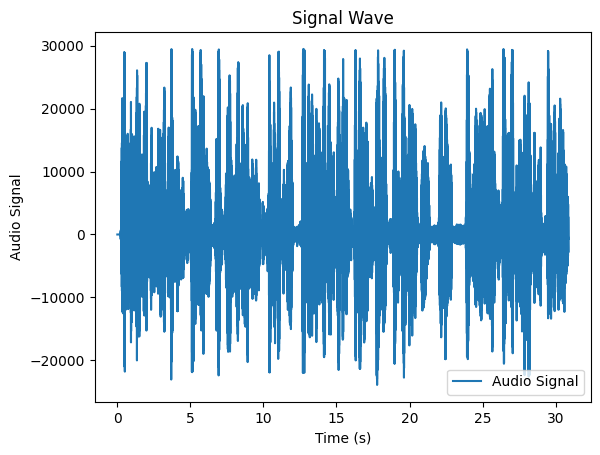

<Figure size 640x480 with 0 Axes>

In [11]:
plot("/kaggle/input/sem-long-project/sem Long project/our data in wav format/puru_3.wav")

/tmp/ipykernel_34/2601419182.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, "int16")


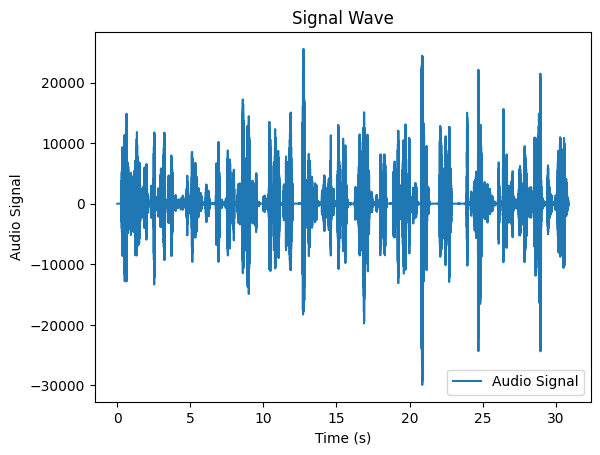

<Figure size 640x480 with 0 Axes>

In [12]:
plot("clean_audio.wav")

In [18]:
snr_value("/kaggle/input/sem-long-project/sem Long project/noisy_trainset_28spk_wav/p226_005.wav", "/kaggle/input/sem-long-project/sem Long project/noisy_trainset_28spk_wav/p226_005.wav")

SNR value in dB:  inf


/tmp/ipykernel_34/1958159344.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  snr_db = 10 * np.log10(signal_power / noise_power)
